In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

sys.path.append(r"../")
from data_loader import xgb_data_loader, xgb_PCA_data_loader, TabnetDataLoader
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score

from xgboost import XGBRegressor

from datetime import datetime

# Load Preprocessed data

In [3]:
IS_CUSTOM = True
USE_VALID = True
n_components = 0
valid_len = 5
DROPS = [
        'assessmentItemID','testId','Timestamp','year','day','minute','second',
    ]

In [4]:
tabnet_data = TabnetDataLoader(IS_CUSTOM=IS_CUSTOM,USE_VALID=USE_VALID,DROPS=DROPS,test_size=0.33,path="../../data")

Start load_data
End load_data
Start preprocessing
assessmentItemID based Parameter estimation is starting...


2526700it [00:18, 133312.10it/s]


testId based Parameter estimation is starting...


2526700it [00:17, 141712.42it/s]


KnowledgeTag based Parameter estimation is starting...


2526700it [00:17, 141229.77it/s]


End preprocessing
Start train_test_split
End train_test_split
Start first3_knowledgeTag_clustering
End first3_knowledgeTag_clustering
Start labeling
End labeling
Start train_valid_split
X_train:(1688753, 66)
y_train:(1688753,)
X_valid:(837203, 66)
y_valid:(837203,)
End train_valid_split


In [5]:
x_train = tabnet_data.X_train
y_train = tabnet_data.y_train
x_valid = tabnet_data.X_valid
y_valid = tabnet_data.y_valid
x_test = tabnet_data.X_test
y_test = tabnet_data.y_test


# XGBRegressor

In [6]:
model = XGBRegressor(tree_method="gpu_hist", gpu_id=0)

if USE_VALID:
    model = XGBRegressor(tree_method="gpu_hist", gpu_id=0, early_stopping_rounds=100)
"""
final params {'alpha': 10, 'booster': 'gbtree', 'colsample_bylevel': 0.9,
 'colsample_bytree': 0.8, 'eta': 0.05, 'gamma': 3, 'lambda': 0, 'max_depth': 9,
  'n_estimators': 200, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 42, 'verbosity': 1}
"""
param_grid = {
    "booster": ["gbtree"],
    "colsample_bylevel": [0.9],
    "colsample_bytree": [0.8],
    "gamma": [3],
    "lambda": [0],
    "alpha": [10],
    "eta": [0.05],
    "max_depth": [9],
    # "min_child_weight": [3],
    # "nrounds":[100000],
    "n_estimators": [300],
    "nthread": [4],
    "objective": ["binary:logistic"],
    "random_state": [42],
    "verbosity": [1],
}
# cv = KFold(n_splits=6, random_state=42, shuffle=True)
cv = StratifiedKFold(n_splits=6, random_state=42, shuffle=True)

gcv = GridSearchCV(
    model,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=4,
    pre_dispatch=8,
    verbose=1,
)

In [7]:
if USE_VALID:
    gcv.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], verbose=True)
else:
    gcv.fit(x_train, y_train, verbose=True)

print("final params", gcv.best_params_)
print("best score", gcv.best_score_)

Fitting 6 folds for each of 1 candidates, totalling 6 fits


/opt/conda/envs/xgb/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/conda/envs/xgb/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/conda/envs/xgb/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/conda/envs/xgb/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the

ValueError: 
All the 6 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/xgboost/core.py", line 506, in inner_f
    return f(**kwargs)
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/xgboost/sklearn.py", line 789, in fit
    self._Booster = train(
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/xgboost/training.py", line 188, in train
    bst = _train_internal(params, dtrain,
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/xgboost/core.py", line 1680, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/xgboost/core.py", line 218, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:53:07] /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/data/../common/common.h:157: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) /opt/conda/envs/xgb/lib/libxgboost.so(+0x98154) [0x7f165025b154]
  [bt] (1) /opt/conda/envs/xgb/lib/libxgboost.so(+0x11b7c2) [0x7f16502de7c2]
  [bt] (2) /opt/conda/envs/xgb/lib/libxgboost.so(xgboost::gbm::GBTree::ConfigureUpdaters()+0xdd) [0x7f165034374d]
  [bt] (3) /opt/conda/envs/xgb/lib/libxgboost.so(xgboost::gbm::GBTree::Configure(std::vector<std::pair<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > >, std::allocator<std::pair<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > > > > const&)+0x331) [0x7f1650358b91]
  [bt] (4) /opt/conda/envs/xgb/lib/libxgboost.so(+0x1bed29) [0x7f1650381d29]
  [bt] (5) /opt/conda/envs/xgb/lib/libxgboost.so(+0x1b6e8e) [0x7f1650379e8e]
  [bt] (6) /opt/conda/envs/xgb/lib/libxgboost.so(XGBoosterUpdateOneIter+0x61) [0x7f1650260681]
  [bt] (7) /opt/conda/envs/xgb/lib/python3.10/lib-dynload/../../libffi.so.7(+0x69dd) [0x7f1663ece9dd]
  [bt] (8) /opt/conda/envs/xgb/lib/python3.10/lib-dynload/../../libffi.so.7(+0x6067) [0x7f1663ece067]



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/xgboost/core.py", line 506, in inner_f
    return f(**kwargs)
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/xgboost/sklearn.py", line 789, in fit
    self._Booster = train(
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/xgboost/training.py", line 188, in train
    bst = _train_internal(params, dtrain,
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/xgboost/core.py", line 1680, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/xgboost/core.py", line 218, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:53:06] /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/data/../common/common.h:157: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) /opt/conda/envs/xgb/lib/libxgboost.so(+0x98154) [0x7f231eb59154]
  [bt] (1) /opt/conda/envs/xgb/lib/libxgboost.so(+0x11b7c2) [0x7f231ebdc7c2]
  [bt] (2) /opt/conda/envs/xgb/lib/libxgboost.so(xgboost::gbm::GBTree::ConfigureUpdaters()+0xdd) [0x7f231ec4174d]
  [bt] (3) /opt/conda/envs/xgb/lib/libxgboost.so(xgboost::gbm::GBTree::Configure(std::vector<std::pair<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > >, std::allocator<std::pair<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > > > > const&)+0x331) [0x7f231ec56b91]
  [bt] (4) /opt/conda/envs/xgb/lib/libxgboost.so(+0x1bed29) [0x7f231ec7fd29]
  [bt] (5) /opt/conda/envs/xgb/lib/libxgboost.so(+0x1b6e8e) [0x7f231ec77e8e]
  [bt] (6) /opt/conda/envs/xgb/lib/libxgboost.so(XGBoosterUpdateOneIter+0x61) [0x7f231eb5e681]
  [bt] (7) /opt/conda/envs/xgb/lib/python3.10/lib-dynload/../../libffi.so.7(+0x69dd) [0x7f23328cc9dd]
  [bt] (8) /opt/conda/envs/xgb/lib/python3.10/lib-dynload/../../libffi.so.7(+0x6067) [0x7f23328cc067]



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/xgboost/core.py", line 506, in inner_f
    return f(**kwargs)
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/xgboost/sklearn.py", line 789, in fit
    self._Booster = train(
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/xgboost/training.py", line 188, in train
    bst = _train_internal(params, dtrain,
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/xgboost/core.py", line 1680, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/xgboost/core.py", line 218, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:53:07] /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/data/../common/common.h:157: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) /opt/conda/envs/xgb/lib/libxgboost.so(+0x98154) [0x7fc91a477154]
  [bt] (1) /opt/conda/envs/xgb/lib/libxgboost.so(+0x11b7c2) [0x7fc91a4fa7c2]
  [bt] (2) /opt/conda/envs/xgb/lib/libxgboost.so(xgboost::gbm::GBTree::ConfigureUpdaters()+0xdd) [0x7fc91a55f74d]
  [bt] (3) /opt/conda/envs/xgb/lib/libxgboost.so(xgboost::gbm::GBTree::Configure(std::vector<std::pair<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > >, std::allocator<std::pair<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > > > > const&)+0x331) [0x7fc91a574b91]
  [bt] (4) /opt/conda/envs/xgb/lib/libxgboost.so(+0x1bed29) [0x7fc91a59dd29]
  [bt] (5) /opt/conda/envs/xgb/lib/libxgboost.so(+0x1b6e8e) [0x7fc91a595e8e]
  [bt] (6) /opt/conda/envs/xgb/lib/libxgboost.so(XGBoosterUpdateOneIter+0x61) [0x7fc91a47c681]
  [bt] (7) /opt/conda/envs/xgb/lib/python3.10/lib-dynload/../../libffi.so.7(+0x69dd) [0x7fc92e0ea9dd]
  [bt] (8) /opt/conda/envs/xgb/lib/python3.10/lib-dynload/../../libffi.so.7(+0x6067) [0x7fc92e0ea067]



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/xgboost/core.py", line 506, in inner_f
    return f(**kwargs)
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/xgboost/sklearn.py", line 789, in fit
    self._Booster = train(
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/xgboost/training.py", line 188, in train
    bst = _train_internal(params, dtrain,
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/xgboost/core.py", line 1680, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/xgboost/core.py", line 218, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:53:07] /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/data/../common/common.h:157: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) /opt/conda/envs/xgb/lib/libxgboost.so(+0x98154) [0x7f84519a1154]
  [bt] (1) /opt/conda/envs/xgb/lib/libxgboost.so(+0x11b7c2) [0x7f8451a247c2]
  [bt] (2) /opt/conda/envs/xgb/lib/libxgboost.so(xgboost::gbm::GBTree::ConfigureUpdaters()+0xdd) [0x7f8451a8974d]
  [bt] (3) /opt/conda/envs/xgb/lib/libxgboost.so(xgboost::gbm::GBTree::Configure(std::vector<std::pair<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > >, std::allocator<std::pair<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > > > > const&)+0x331) [0x7f8451a9eb91]
  [bt] (4) /opt/conda/envs/xgb/lib/libxgboost.so(+0x1bed29) [0x7f8451ac7d29]
  [bt] (5) /opt/conda/envs/xgb/lib/libxgboost.so(+0x1b6e8e) [0x7f8451abfe8e]
  [bt] (6) /opt/conda/envs/xgb/lib/libxgboost.so(XGBoosterUpdateOneIter+0x61) [0x7f84519a6681]
  [bt] (7) /opt/conda/envs/xgb/lib/python3.10/lib-dynload/../../libffi.so.7(+0x69dd) [0x7f84657149dd]
  [bt] (8) /opt/conda/envs/xgb/lib/python3.10/lib-dynload/../../libffi.so.7(+0x6067) [0x7f8465714067]



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/xgboost/core.py", line 506, in inner_f
    return f(**kwargs)
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/xgboost/sklearn.py", line 789, in fit
    self._Booster = train(
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/xgboost/training.py", line 188, in train
    bst = _train_internal(params, dtrain,
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/xgboost/core.py", line 1680, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/xgboost/core.py", line 218, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:53:10] /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/data/../common/common.h:157: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) /opt/conda/envs/xgb/lib/libxgboost.so(+0x98154) [0x7f231eb59154]
  [bt] (1) /opt/conda/envs/xgb/lib/libxgboost.so(+0x11b7c2) [0x7f231ebdc7c2]
  [bt] (2) /opt/conda/envs/xgb/lib/libxgboost.so(xgboost::gbm::GBTree::ConfigureUpdaters()+0xdd) [0x7f231ec4174d]
  [bt] (3) /opt/conda/envs/xgb/lib/libxgboost.so(xgboost::gbm::GBTree::Configure(std::vector<std::pair<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > >, std::allocator<std::pair<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > > > > const&)+0x331) [0x7f231ec56b91]
  [bt] (4) /opt/conda/envs/xgb/lib/libxgboost.so(+0x1bed29) [0x7f231ec7fd29]
  [bt] (5) /opt/conda/envs/xgb/lib/libxgboost.so(+0x1b6e8e) [0x7f231ec77e8e]
  [bt] (6) /opt/conda/envs/xgb/lib/libxgboost.so(XGBoosterUpdateOneIter+0x61) [0x7f231eb5e681]
  [bt] (7) /opt/conda/envs/xgb/lib/python3.10/lib-dynload/../../libffi.so.7(+0x69dd) [0x7f23328cc9dd]
  [bt] (8) /opt/conda/envs/xgb/lib/python3.10/lib-dynload/../../libffi.so.7(+0x6067) [0x7f23328cc067]



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/xgboost/core.py", line 506, in inner_f
    return f(**kwargs)
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/xgboost/sklearn.py", line 789, in fit
    self._Booster = train(
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/xgboost/training.py", line 188, in train
    bst = _train_internal(params, dtrain,
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/xgboost/core.py", line 1680, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/opt/conda/envs/xgb/lib/python3.10/site-packages/xgboost/core.py", line 218, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:53:11] /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/data/../common/common.h:157: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) /opt/conda/envs/xgb/lib/libxgboost.so(+0x98154) [0x7f84519a1154]
  [bt] (1) /opt/conda/envs/xgb/lib/libxgboost.so(+0x11b7c2) [0x7f8451a247c2]
  [bt] (2) /opt/conda/envs/xgb/lib/libxgboost.so(xgboost::gbm::GBTree::ConfigureUpdaters()+0xdd) [0x7f8451a8974d]
  [bt] (3) /opt/conda/envs/xgb/lib/libxgboost.so(xgboost::gbm::GBTree::Configure(std::vector<std::pair<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > >, std::allocator<std::pair<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > > > > const&)+0x331) [0x7f8451a9eb91]
  [bt] (4) /opt/conda/envs/xgb/lib/libxgboost.so(+0x1bed29) [0x7f8451ac7d29]
  [bt] (5) /opt/conda/envs/xgb/lib/libxgboost.so(+0x1b6e8e) [0x7f8451abfe8e]
  [bt] (6) /opt/conda/envs/xgb/lib/libxgboost.so(XGBoosterUpdateOneIter+0x61) [0x7f84519a6681]
  [bt] (7) /opt/conda/envs/xgb/lib/python3.10/lib-dynload/../../libffi.so.7(+0x69dd) [0x7f84657149dd]
  [bt] (8) /opt/conda/envs/xgb/lib/python3.10/lib-dynload/../../libffi.so.7(+0x6067) [0x7f8465714067]




In [ ]:
# SAVE OUTPUT
model = gcv.best_estimator_
sub = pd.read_csv("/opt/ml/input/data/sample_submission.csv")
sub["prediction"] = model.predict(x_test)

output_dir = "./output/"
now = datetime.now()
now_str = "{:%Y-%m-%d_%H:%M:%S}".format(now)
file_name = f"XGB_R_grid_kfold_custom_submission_{now_str}.csv"
write_path = os.path.join(output_dir, file_name)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, "w", encoding="utf8") as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(sub["prediction"]):
        w.write("{},{}\n".format(id, p))

writing prediction : ./output/XGB_R_grid_kfold_custom_submission_2022-11-28_12:05:48.csv


In [ ]:
def get_accuracy(PRED_PATH=file_name):
    threshold = 0.5
    ANSWER_PATH = "../../data/custom_answer.csv"

    submission_result = pd.read_csv(PRED_PATH)
    answer = pd.read_csv(ANSWER_PATH)

    y_pred, y = submission_result["prediction"], answer["prediction"]

    return f"accuracy_score: {accuracy_score(y,y_pred.apply(lambda x: 1 if x > threshold else 0))}\nroc  auc_score: {roc_auc_score(y,y_pred)}"

In [ ]:
if IS_CUSTOM:
    print(get_accuracy("output/" + file_name))


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

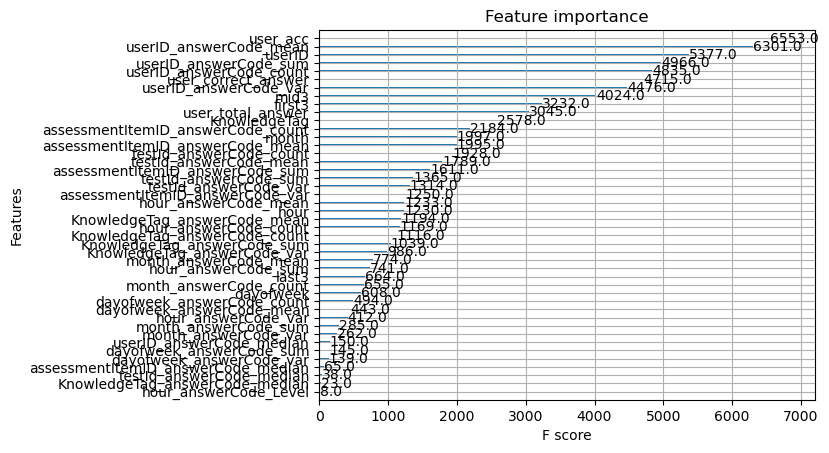

In [ ]:
from xgboost import plot_importance
plot_importance(model)

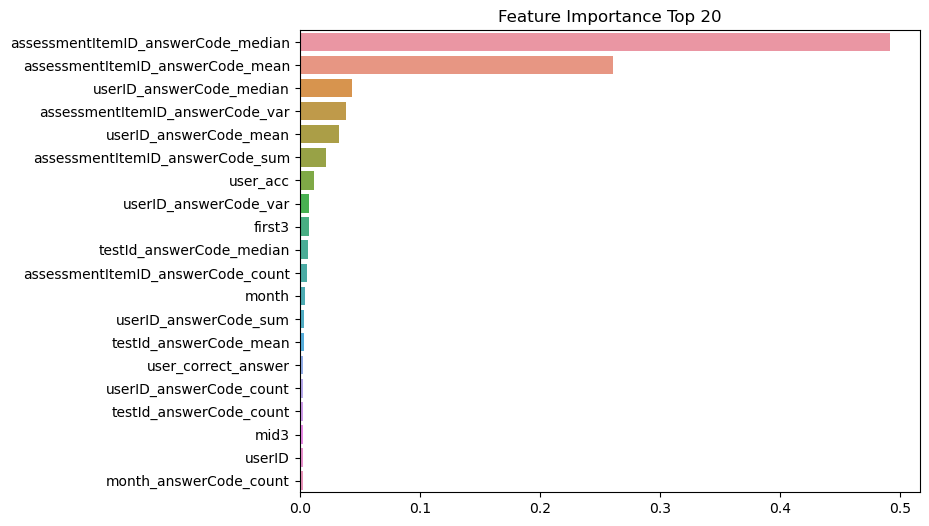

In [ ]:

ft_importance_values = model.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
ft_series = pd.Series(ft_importance_values, index = x_train.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(8,6))
plt.title('Feature Importance Top 20')
sns.barplot(x=ft_top20, y=ft_top20.index)
plt.show()

In [ ]:
# answerCode 평균이 높은 hour를 feature
# userId, best_공부_시간
# 권준혁: 22시
# 강태훈: 21시 -> userID, hour로 groupby -> ["answerCode"].agg("mean")

In [ ]:
--++++-+-++-+------------`
.0....clf = TabNetRegressor(
    optimizer_fn=torch.optim.AdamW,
    optimizer_params=dict(lr=0.0001),
    # scheduler_params={"step_size":100, # how to use learning rate scheduler
    #                   "gamma":0.9},
    # scheduler_params={'factor':0.2, 'patience':5, 'min_lr':0.001},
    # scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    scheduler_params={
        'T_0':10, 
        'T_mult':1, 
        'eta_max':0.1, 
        'T_up':3,
        'gamma':0.7
        },
    scheduler_fn=CosineAnnealingWarmUpRestarts,
    mask_type='sparsemax', # This will be overwritten if using pretrain model
)

clf.fit(
    X_train=X_train, y_train=y_train,
    max_epochs=30,
    patience=20,
    eval_set=[(X_valid, y_valid)],
    eval_name=['valid'],
    batch_size=BS//(2**4),
    virtual_batch_size=BS//(2**4),
    num_workers=1,
    eval_metric=[Eval],
    # from_unsupervised=unsupervised_model
)

/opt/conda/envs/boosting_models/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.38068 | valid_roc_auc_score: 0.81413 |  0:01:59s
epoch 1  | loss: 0.03858 | valid_roc_auc_score: 0.98659 |  0:03:57s
epoch 2  | loss: 0.02666 | valid_roc_auc_score: 0.97321 |  0:05:56s
epoch 3  | loss: 0.0269  | valid_roc_auc_score: 0.98665 |  0:07:54s
epoch 4  | loss: 0.02552 | valid_roc_auc_score: 0.97756 |  0:09:55s
epoch 5  | loss: 0.0236  | valid_roc_auc_score: 0.97907 |  0:11:52s
epoch 6  | loss: 0.02059 | valid_roc_auc_score: 0.94976 |  0:13:51s
epoch 7  | loss: 0.01782 | valid_roc_auc_score: 0.97431 |  0:15:48s
epoch 8  | loss: 0.01429 | valid_roc_auc_score: 0.99432 |  0:17:47s
epoch 9  | loss: 0.01012 | valid_roc_auc_score: 0.99737 |  0:19:45s
epoch 10 | loss: 0.0082  | valid_roc_auc_score: 0.9984  |  0:21:42s
epoch 11 | loss: 0.01519 | valid_roc_auc_score: 0.99323 |  0:23:41s
epoch 12 | loss: 0.01881 | valid_roc_auc_score: 0.97432 |  0:25:38s
epoch 13 | loss: 0.02116 | valid_roc_auc_score: 0.98316 |  0:27:34s
epoch 14 | loss: 0.02046 | valid_roc_auc_score: 

/opt/conda/envs/boosting_models/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
